# CDR Experiments via Pymagicc
##### CC-BY 4.0 2020 @safiume
##### pymagicc AGPL-3

In [1]:
# NBVAL_IGNORE_OUTPUT
import sys, re
from os import listdir
from os.path import join, dirname
from pprint import pprint
import expectexception
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import f90nml

In [2]:
#Disable warning supression if running locally
import warnings
warnings.simplefilter("ignore", category=Warning, lineno=0, append=False)

In [3]:
import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, read_cfg_file, NoReaderWriterError
from pymagicc.scenarios import ( rcp26, rcp45 )
print(pymagicc.__version__)
print(sys.version)
rcp26.__class__.__bases__

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


2.0.0rc8+19.g7aade1e.dirty
3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


(scmdata.run.ScmRun,)

In [4]:
## List of experiments in declines
declines = ["emax", "lmax", "emin", "lmin"]
SCEN_DIR = "SCEN"
MAGICC6_DIR = join("..", "CDRRUN")

# Start MAGICC at 1720 or before
# The baseline for 0 °C will be recalculated based the mean
# temp for 1720-1800.
## Start of MAGICC settings
magcfg = {"startyear" : 1720,
          "endyear" : 2500,
          "core_climatesensitivity" : 2.6,  #BERN sensitivity
          "co2_switchfromconc2emis_year" : 2010,
          "rf_mhalo_constantafteryr" : 2250,
          "rf_fgas_constantafteryr" : 2250,
          "out_forcing" : 1,
          "out_emissions" : 1,
          "out_concentrations" : 1 }
### End MAGICC Settings

In [5]:
# Reassign startyear to include the year 1720.
graphstart = magcfg['startyear']
if magcfg['startyear'] > 1720:
    magcfg['startyear'] = 1720

## load experiments scen file data
for n, name in enumerate (declines):
    declinefile = join(SCEN_DIR, "ONC" + name + ".SCEN")
    declines[n] = MAGICCData(declinefile,
                             columns={"model": ["CDRex"], "scenario": [name]})

img119 = MAGICCData(join(SCEN_DIR, 'imgs119.SCEN'), 
                    columns={"model": ["IMAGE"], "scenario": ['SSP119']}, inplace=True)
declines.append(img119)
declines[2].timeseries().head(3)

time                                                                                             2005-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial       8.030   
                                                     Emissions|CO2|MAGICC AFOLU                       1.180   
                                         Mt CH4 / yr Emissions|CH4                                  315.903   

time                                                                                             2010-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.1209   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3732   
                                         Mt CH4 / yr Emissions|CH4                                 332.0000   

time                                                                                             2011-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.4954   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3204   
                                         Mt CH4 / yr Emissions|CH4                                 335.0000   

time                                                                                             2012-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.6670   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3786   
                                         Mt CH4 / yr Emissions|CH4                                 338.0000   

time                                                                                             2013-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.7651   
                                                     Emissions|CO2|MAGICC AFOLU                      1.4088   
                                         Mt CH4 / yr Emissions|CH4                                 341.0000   

time                                                                                             2014-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.8475   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3788   
                                         Mt CH4 / yr Emissions|CH4                                 344.0000   

time                                                                                             2015-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.8306   
                                                     Emissions|CO2|MAGICC AFOLU                      1.5191   
                                         Mt CH4 / yr Emissions|CH4                                 347.0000   

time                                                                                             2016-01-01 

In [6]:
# Calculate how much carbon to remove to achieve 300 ppm at 2050
CRsyr = 2021
Bkyr = 2050
# CO₂ gas is in GtC
AnthroC = 455.08
LuC = 161.09
CCCxFF = 187
CCCxLuC = 103

LuC_2050 = LuC - CCCxLuC
landsnk_yrly = LuC_2050/((Bkyr) - CRsyr)
landsnc_remainingYr = CCCxLuC/(2100 - Bkyr)

AC_2050 = AnthroC - CCCxFF
Peak_to_bk_yr = AC_2050/((Bkyr) - CRsyr)
Remaining_per_yr = CCCxFF/(2100 - Bkyr)

In [7]:
# Copy lmin data into new experiment
CCCx2050 = declines[3]
CCC_df = CCCx2050.timeseries()

# Kigali reference for later
# kigali_yrs = 2019,2024,2025,2029,2034,2036
# ki_mo_gasses_F = HFC134a, HFC245fa, HFC277ea, 
#                 HFC4310, HFC32, HFC125, HFC143a, HFC23
# sf6-eu 30% by 2030

ems_ff = 'Emissions|CO2|MAGICC Fossil and Industrial'
ems_luc = 'Emissions|CO2|MAGICC AFOLU'
emsf = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr', ems_ff)
emsluc = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr',ems_luc)

CCC_df = CCC_df.rename(index={"lmin":"CCCx2050"})

# Zero out data past 2099 
CCC_df.loc[emsf, datetime(2100,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_df.loc[emsluc, datetime(2100,1,1,0) : datetime(2150,1,1,0)] = 0

# Set removal according to forumlas in previous cell
CCC_df.loc[emsluc, datetime(2021,1,1) : datetime(2049,1,1)] = -landsnk_yrly
CCC_df.loc[emsluc, datetime(2050,1,1) : datetime(2099,1,1)] = -landsnc_remainingYr
CCC_df.loc[emsf, datetime(2021,1,1) : datetime(2049,1,1)] = -Peak_to_bk_yr
CCC_df.loc[emsf, datetime(2050,1,1) : datetime(2099,1,1)] = -Remaining_per_yr 

# rewrite CCCx2050 from timeseries and wrap in MAGICCData
CCCx2050 = MAGICCData(CCC_df.copy())
#CCC_df.to_csv('CCCx2050.csv')

CCC_flat = CCC_df.copy()
CCC_flat.loc[emsf, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat.loc[emsluc, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat = CCC_flat.rename(index={"CCCx2050":"CCCxflat"})
CCCxflat = MAGICCData(CCC_flat.copy())

print("Diagnostic Output")
print(CCC_df.head(2).iloc[:,[10]])
print(CCC_df.head(2).iloc[:,[32]])
print(CCC_df.head(2).iloc[:,[42]])
CCCx2050.timeseries().head(3)

Diagnostic Output
time                                                                                           2019-01-01
climate_model model region scenario todo unit      variable                                              
unspecified   CDRex World  CCCx2050 SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial       10.00
                                                   Emissions|CO2|MAGICC AFOLU                        1.25
time                                                                                           2041-01-01
climate_model model region scenario todo unit      variable                                              
unspecified   CDRex World  CCCx2050 SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial   -9.244138
                                                   Emissions|CO2|MAGICC AFOLU                   -2.003103
time                                                                                           2051-01-01
climate_model model region s

time                                                                                             2005-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial       8.030   
                                                     Emissions|CO2|MAGICC AFOLU                       1.180   
                                         Mt CH4 / yr Emissions|CH4                                  315.903   

time                                                                                             2010-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.1209   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3732   
                                         Mt CH4 / yr Emissions|CH4                                 332.0000   

time                                                                                             2011-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.4954   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3204   
                                         Mt CH4 / yr Emissions|CH4                                 335.0000   

time                                                                                             2012-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.6670   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3786   
                                         Mt CH4 / yr Emissions|CH4                                 338.0000   

time                                                                                             2013-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.7651   
                                                     Emissions|CO2|MAGICC AFOLU                      1.4088   
                                         Mt CH4 / yr Emissions|CH4                                 341.0000   

time                                                                                             2014-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.8475   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3788   
                                         Mt CH4 / yr Emissions|CH4                                 344.0000   

time                                                                                             2015-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.8306   
                                                     Emissions|CO2|MAGICC AFOLU                      1.5191   
                                         Mt CH4 / yr Emissions|CH4                                 347.0000   

time                                                                                             2016-01-01 

In [12]:
# Force sample rcp26 to end CR at 2101
rcp26df = rcp26.timeseries()
rcp26df = rcp26df.rename(columns={datetime(2125,1,1,0):datetime(2101,1,1,0)})
rcp26df.loc[:, datetime(2101,1,1,0) : datetime(2500,1,1,0)] = 0
rcp26 = MAGICCData(rcp26df.copy())

# Scenarios

The five RCP scenarios and experimental declines are loaded as DataFrames in pyhector. They contain the following emissions:

In [13]:
#rcp26.filter(region='World').timeseries().loc[:,datetime(2090,1,1,0):datetime(2101,1,1,0)]
rcp26.filter(region='World').timeseries().head(2)

time                                                                                           2000-01-01 00:00:00  \
climate_model model region scenario todo unit      variable                                                          
unspecified   IMAGE World  RCP26    SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial               6.7350   
                                                   Emissions|CO2|MAGICC AFOLU                               1.1488   

time                                                                                           2001-01-01 00:00:00  \
climate_model model region scenario todo unit      variable                                                          
unspecified   IMAGE World  RCP26    SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial                6.896   
                                                   Emissions|CO2|MAGICC AFOLU                                1.132   

time                                                                                           2002-01-01 00:00:00  \
climate_model model region scenario todo unit      variable                                                          
unspecified   IMAGE World  RCP26    SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial               6.9490   
                                                   Emissions|CO2|MAGICC AFOLU                               1.2317   

time                                                                                           2003-01-01 00:00:00  \
climate_model model region scenario todo unit      variable                                                          
unspecified   IMAGE World  RCP26    SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial               7.2860   
                                                   Emissions|CO2|MAGICC AFOLU                               1.2256   

time                                                                                           2004-01-01 00:00:00  \
climate_model model region scenario todo unit      variable                                                          
unspecified   IMAGE World  RCP26    SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial               7.6720   
                                                   Emissions|CO2|MAGICC AFOLU                               1.2428   

time                                                                                           2005-01-01 00:00:00  \
climate_model model region scenario todo unit      variable                                                          
unspecified   IMAGE World  RCP26    SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial               7.9710   
                                                   Emissions|CO2|MAGICC AFOLU                               1.1955   

time                                                                                           2006-01-01 00:00:00  \
climate_model model region scenario todo unit      variable                                                          
unspecified   IMAGE World  RCP26    SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial               8.1426   
                                                   Emissions|CO2|MAGICC AFOLU                               1.1677   

time                                                                                           2007-01-01 00:00:00  \
climate_model model region scenario todo unit      variable                                                          
unspecified   IMAGE World  RCP26    SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial               8.3135   
                                                   Emissions|CO2|MAGICC AFOLU                               1.1399   

time                                                                                           2010-01-01 00:00:00  \
climate_model model region scenario todo unit      variable                                       

In [ ]:
rcp26.filter(region='World').head(2)

They are split up in regions:

In [ ]:
rcp26["region"].unique()

They have the following units:

In [ ]:
#pymagicc.units
rcp26["unit"].head()

In [ ]:
categories_to_plot = rcp26["variable"].drop_duplicates().tolist()

for g in rcp26.filter(
    variable=categories_to_plot,
    year=range(2000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

In [ ]:
categories_to_plot = rcp26["variable"].drop_duplicates().tolist()

for g in CCCx2050.filter(
    region="World",
    variable=categories_to_plot,
    year=range(2000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="scenario").set_title(g.get_unique_meta("variable", True))

## Running MAGICC

A single `pymagicc` run doesn't take long and returns a Pandas Dict.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [9]:
# Adjust baseline temp to the mean of 1720 to 1800 
# per https://doi.org/10.1175/BAMS-D-16-0007.1

styr = 1720
eyr = 1800
sitv = 2.6
lsitv = sitv - 1.5
hsitv = 5.2

selectftr = {
    "region": "World",
    "variable": "Surface Temperature",
    "year": range(magcfg["startyear"], magcfg["endyear"]),
}

In [10]:
def meanbln(scen,mgdata,**cfgs):
    origts = mgdata.timeseries()
    default = pymagicc.run(scen, **cfgs)
    pmean = default.filter(**selectftr).timeseries().loc[:,datetime(styr, 1, 1): datetime(eyr, 1, 1)].T.mean()
    defaultts = default.timeseries()
    updated = defaultts.xs((selectftr['variable']),level = ('variable'), drop_level=False).add(pmean[0])
    origts.loc[updated.index.values] = updated
    return(MAGICCData(origts.copy()))

In [11]:
vars = ["Surface Temperature","Radiative Forcing",
        "Atmospheric Concentrations|CO2","Emissions|CO2|MAGICC Fossil and Industrial",
        "Emissions|CO2|MAGICC AFOLU"]
x = (datetime(graphstart, 1, 1), datetime(magcfg["endyear"], 1, 1))

In [14]:
res = ""
%time res = pymagicc.run(rcp26, **magcfg)  #need to create res of type MAGICCData
res = meanbln(rcp26,res,**magcfg)

# Toggle to run and graph all the experiments
#declines.append(CCCxflat)
#declines.append(CCCx2050)

#for scen in declines:
#    tmprs = pymagicc.run(scen, **magcfg)
#    res = res.append(meanbln(scen, tmprs, **magcfg))
    
#for cccsn in CCCxflat,CCCx2050:
#    tmprs = pymagicc.run(CCCx2050, **magcfg)
#    res = res.append(meanbln(CCCx2050,tmprs,**magcfg))

tmprs = pymagicc.run(CCCx2050, **magcfg)
res = meanbln(CCCx2050,tmprs,**magcfg)

CPU times: user 3.96 s, sys: 211 ms, total: 4.17 s
Wall time: 10.2 s


## Graph Output from previous cell

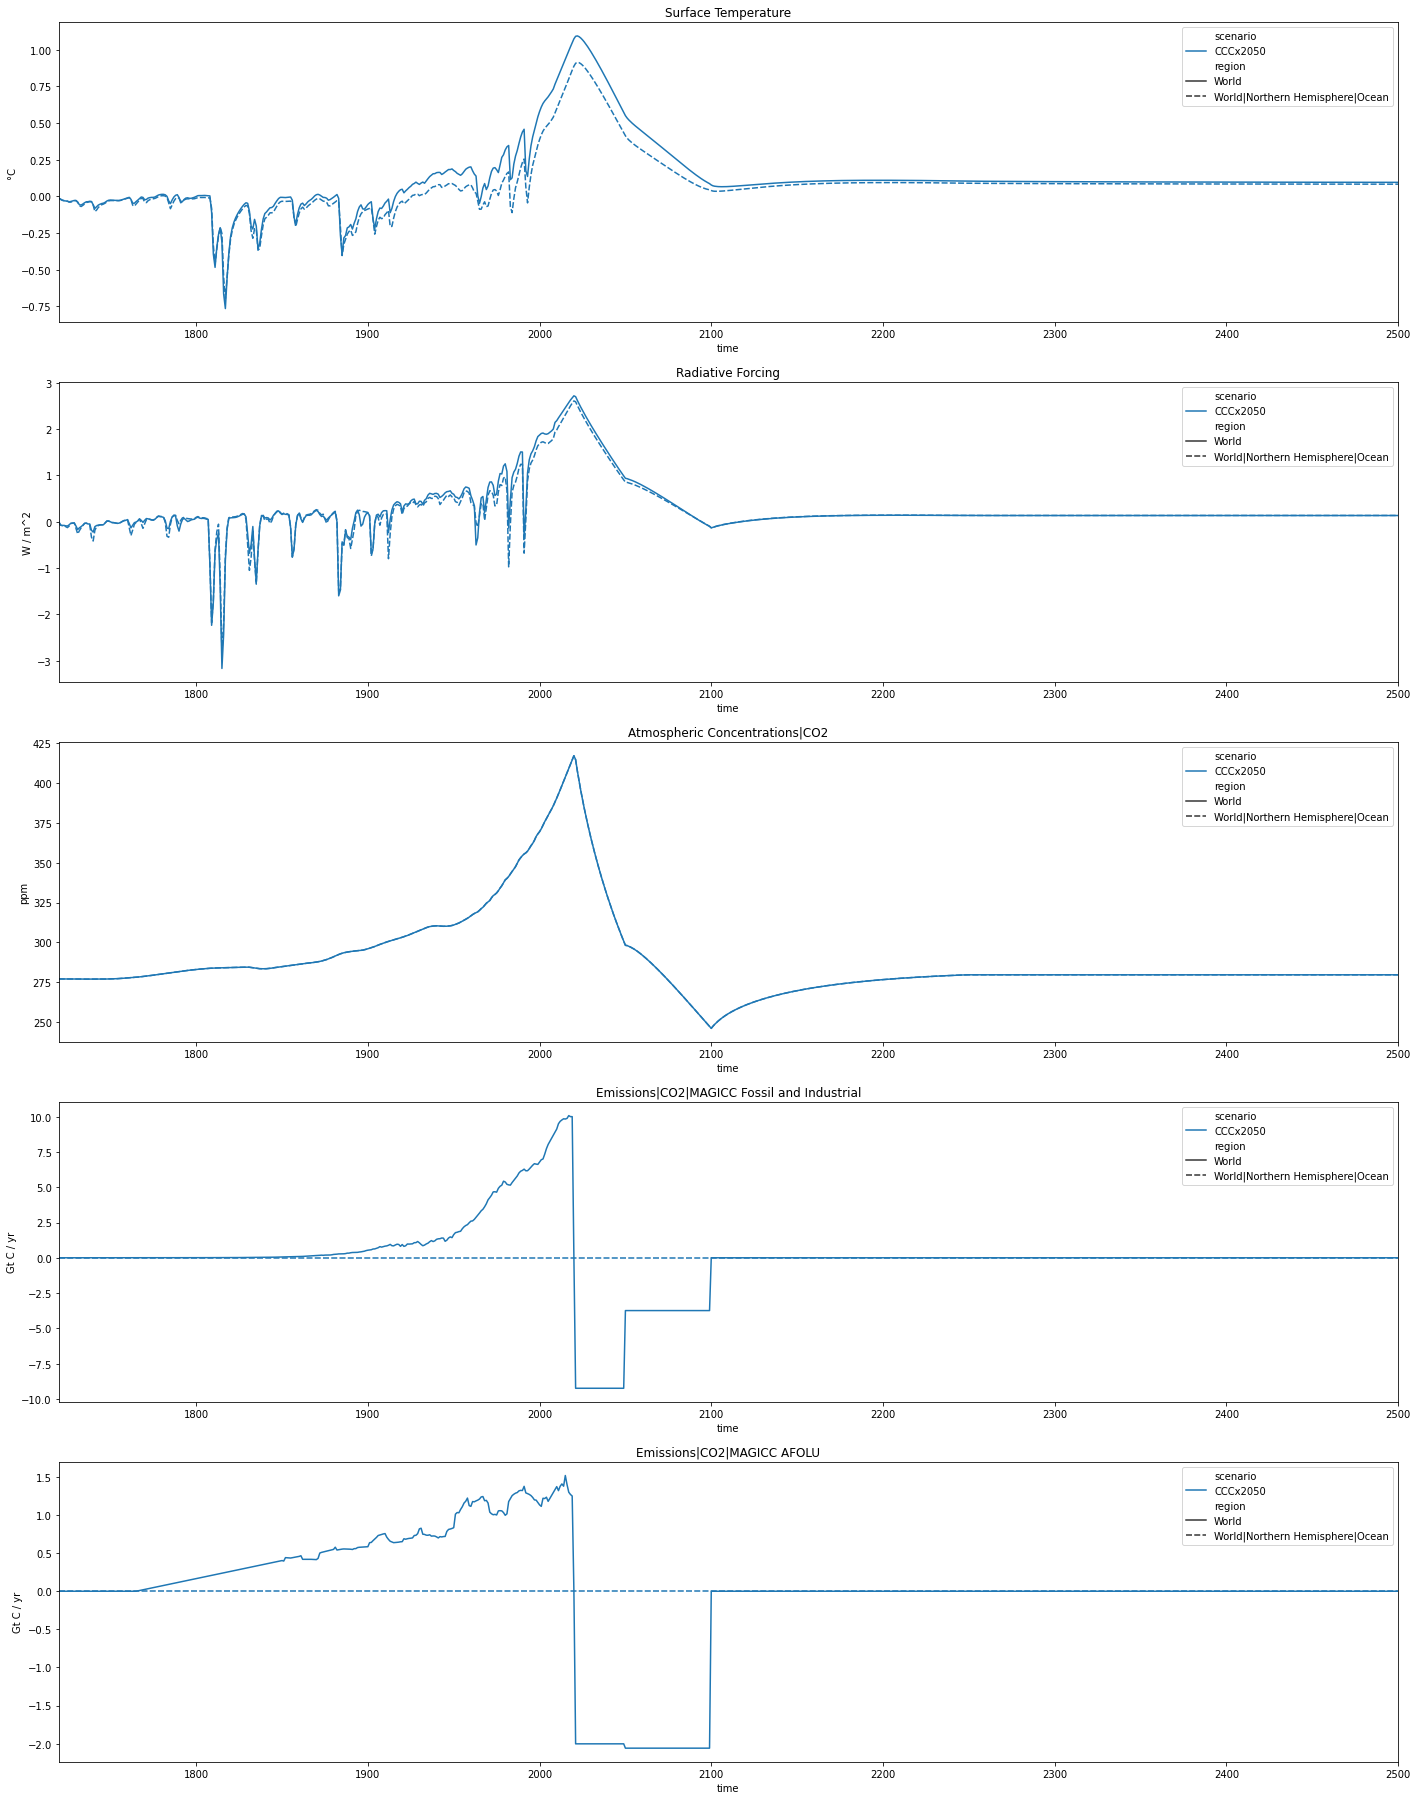

In [15]:
fig, axes = plt.subplots((len(vars)), 1, figsize=(24, 32))
for n, var in enumerate(vars):
    res.filter(variable=var,region=["World","*Nor*Ocean"]).lineplot(hue="scenario", style="region", ax=axes[n])
    ylab = res.filter(variable=var)["unit"].iloc[[0]].all() 
    if ylab == 'K':
        ylab = '°C'
    axes[n].set_ylabel(ylab)
    axes[n].set_title(var)                        
    axes[n].set_xlim(x)
    axes[n].legend(loc='upper right')


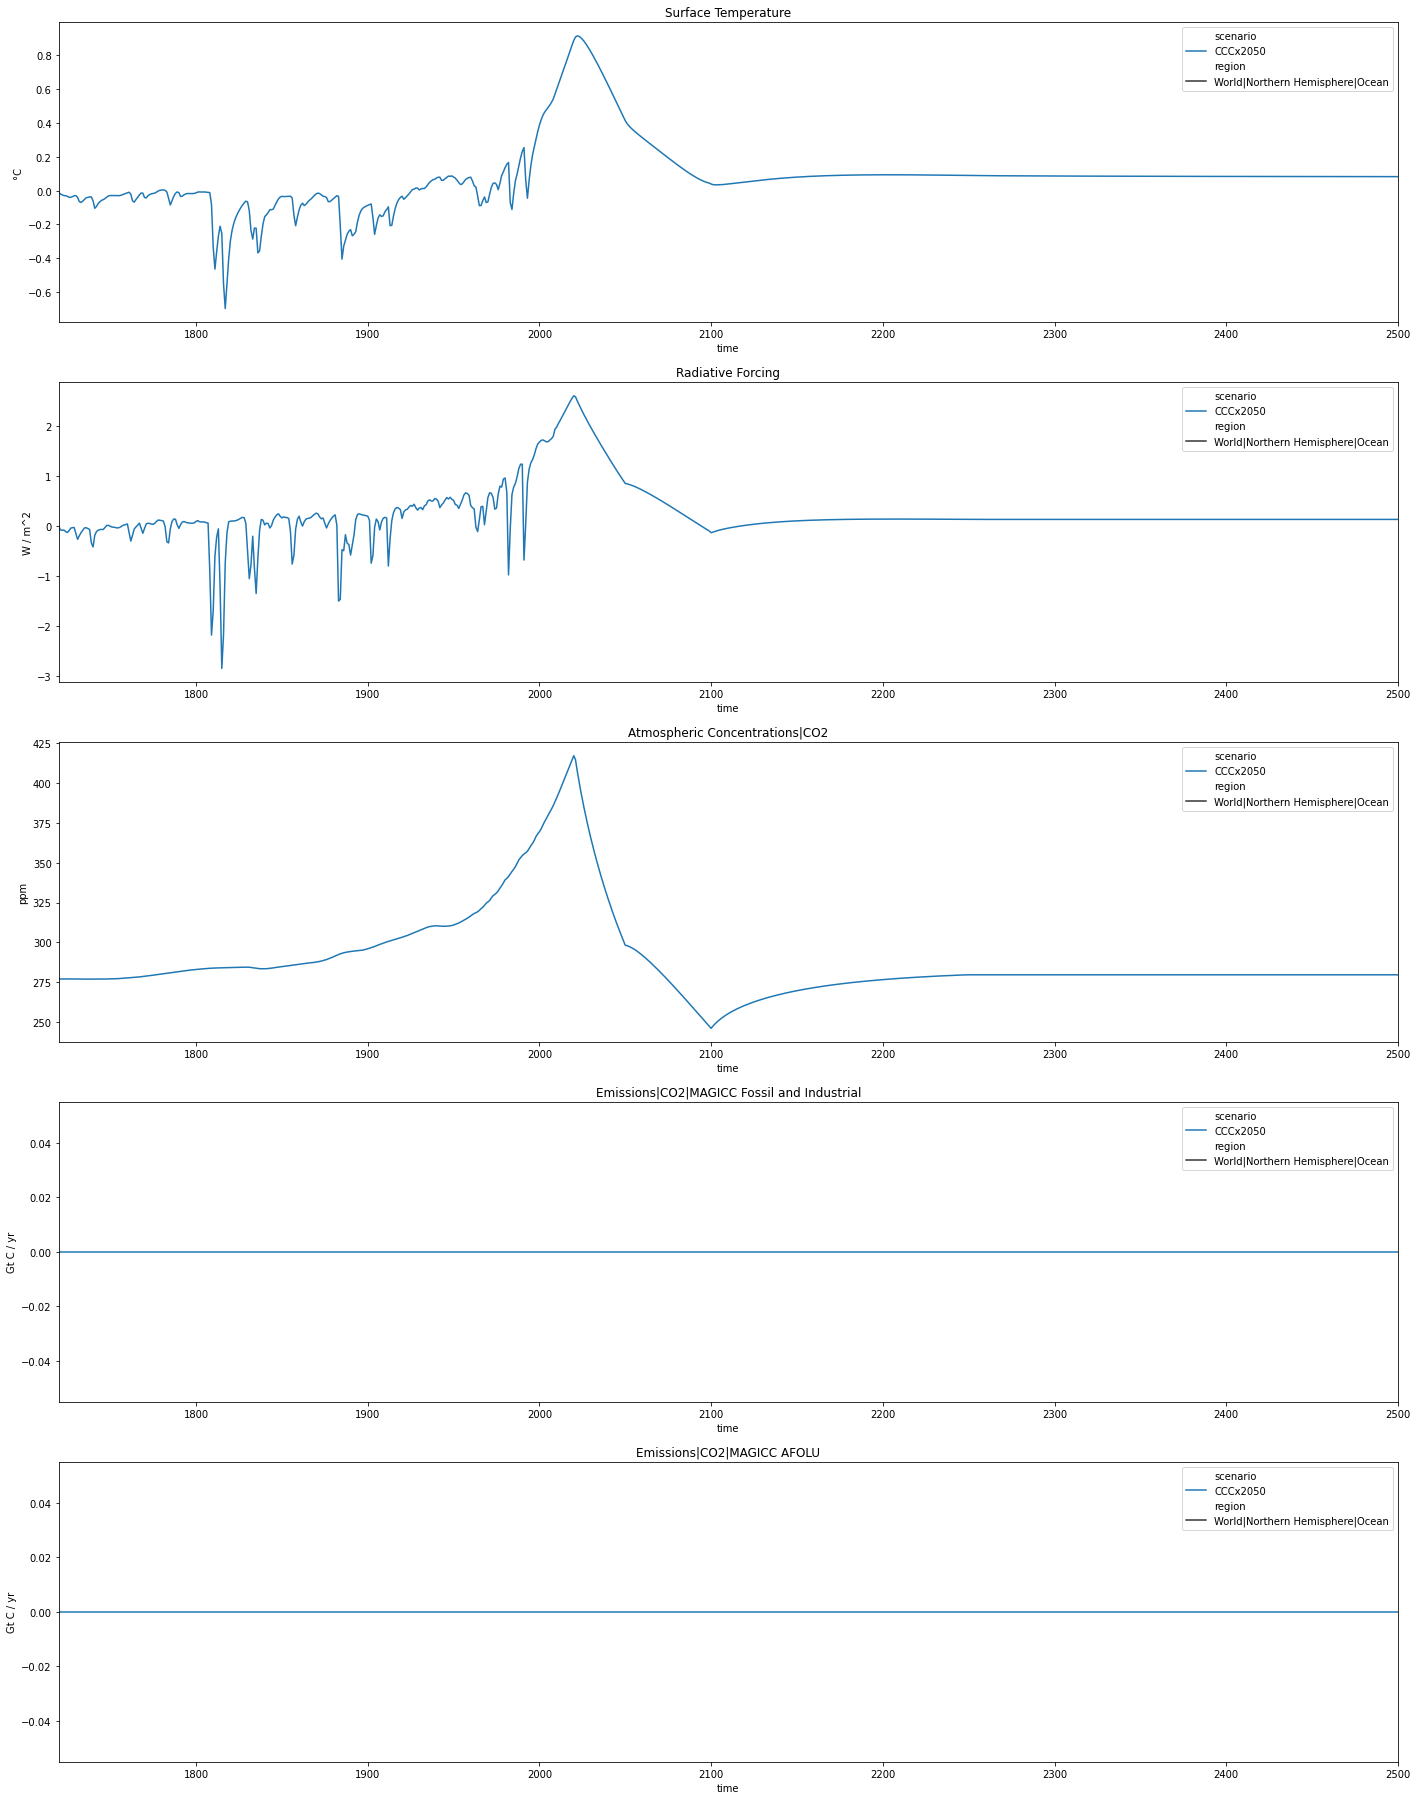

In [16]:
fig, axes = plt.subplots((len(vars)), 1, figsize=(24, 32))
for n, var in enumerate(vars):
    res.filter(variable=var,region="*Nor*Ocean").lineplot(hue="scenario", style="region", ax=axes[n])
    ylab = res.filter(variable=var)["unit"].iloc[[0]].all()
    if ylab == 'K':
        ylab = '°C'
    axes[n].set_ylabel(ylab)
    axes[n].set_title(var)
    axes[n].set_xlim(x)
    axes[n].legend(loc='upper right')


# Diagnostic Output

In [17]:
for dt in 2020,2050,2100,2500:
    for var in vars,ems_ff:
        print(res.filter(variable = var,
                         region='World').timeseries().loc[:,datetime(dt,1,1)])
    for cgas in ems_ff,ems_luc:
        print("Cumulative CO₂ 1750 to", dt)
        print(res.filter(variable=cgas,
                         region='World').timeseries().loc[:,datetime(1750,1,1):datetime(dt,1,1)].sum(axis=1))

res.filter(variable = "Atmospheric Concentrations|CO2",region="World").timeseries().loc[:,datetime(2045,1,1):datetime(2052,1,1)] >= 300
#res.filter(variable = "Atmospheric Concentrations|CO2",region="World").timeseries().loc[:,datetime(1909,1,1):datetime(1920,1,1)] >= 299


climate_model  model  region  scenario  todo          unit       variable                                  
MAGICC6        CDRex  World   CCCx2050  not_relevant  ppm        Atmospheric Concentrations|CO2                417.306080
                                                      W / m^2    Radiative Forcing                               2.720494
                                                      K          Surface Temperature                             1.074107
                                                      Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial      0.000000
                                                                 Emissions|CO2|MAGICC AFOLU                      0.000000
Name: 2020-01-01 00:00:00, dtype: float64
climate_model  model  region  scenario  todo          unit       variable                                  
MAGICC6        CDRex  World   CCCx2050  not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    0.0
Name: 2020-01-01 

,,,,,,time,2045-01-01 00:00:00,2046-01-01 00:00:00,2047-01-01 00:00:00,2048-01-01 00:00:00,2049-01-01 00:00:00,2050-01-01 00:00:00,2051-01-01 00:00:00,2052-01-01 00:00:00
climate_model,model,region,scenario,todo,unit,variable,,,,,,,,
MAGICC6,CDRex,World,CCCx2050,not_relevant,ppm,Atmospheric Concentrations|CO2,True,True,True,True,True,False,False,False


The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

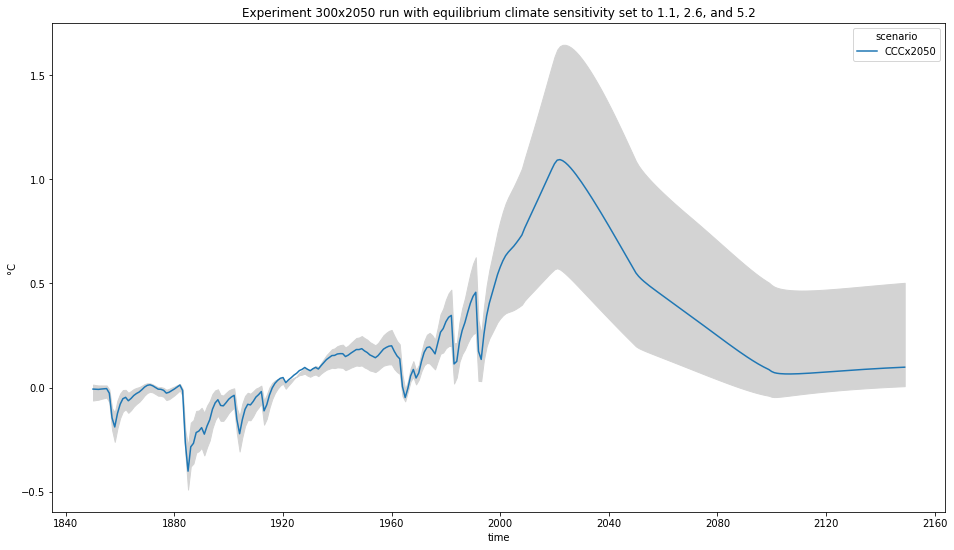

In [18]:
scenario = CCCx2050
runs = {"default":sitv, 
        "low":lsitv,
        "high":hsitv}
runsdf = {}
mcfg = magcfg.copy()

for rn in runs:
    mcfg['core_climatesensitivity'] = runs[rn]
    newrn = pymagicc.run(scenario, **mcfg)
    runsdf[rn] = meanbln(scenario, newrn, **mcfg)

filtering = {"region": "World", "variable": "Surface Temperature", 
             "year": range(1850, 2150)}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
runsdf['default'].filter(**filtering).line_plot(x="time", ax=ax)
plt.fill_between(
    runsdf['default'].filter(**filtering)['time'],
    runsdf['low'].filter(**filtering).timeseries().values.squeeze(),
    runsdf['high'].filter(**filtering).timeseries().values.squeeze(),
    color="lightgray"
)

plt.title(
    (f"Experiment 300x2050 run with equilibrium climate sensitivity set to {lsitv}, {sitv}, and {hsitv}")
)
plt.ylabel("°C");